In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from scipy import stats
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import matplotlib.pyplot as plt
from models.networks import get_model, B_12_Wi_1024

/Users/lisa/Desktop/code_projects/dl_project/bachmann_venv39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#  sanity check with untrained model - blurry results 
# model=B_12_Wi_1024(dim_in=64 ** 2 * 3, dim_out=10, load_device='cpu', checkpoint=None)

In [3]:
# standard model 
#model = get_model(architecture='B_12-Wi_1024', resolution=64, num_classes=10,  checkpoint='in21k_cifar10', load_device='cpu')

In [26]:
checkpoint_gregor=torch.load('/Users/lisa/Desktop/code_projects/dl_project/scaling_mlps_mirror/models/checkpoints/B-6_Wi-512_res_64_cifar10_epochs_20_weights',  map_location=torch.device('cpu'))

In [27]:
checkpoint_exp=torch.load('/Users/lisa/Desktop/code_projects/dl_project/scaling_mlps_mirror/models/checkpoints/wandb_vhd7bodg__epoch_1140__compute_611890379735040__B_6-Wi_512__imagenette-160__dropout_0 (1).3__rotations20__mixup__64',  map_location=torch.device('cpu'))

In [32]:
set(checkpoint_gregor.keys())-set(checkpoint_exp['model'].keys())

{'blocks.0.block.2.bias',
 'blocks.0.block.2.weight',
 'blocks.1.block.2.bias',
 'blocks.1.block.2.weight',
 'blocks.2.block.2.bias',
 'blocks.2.block.2.weight',
 'blocks.3.block.2.bias',
 'blocks.3.block.2.weight',
 'blocks.4.block.2.bias',
 'blocks.4.block.2.weight',
 'blocks.5.block.2.bias',
 'blocks.5.block.2.weight'}

In [31]:
set(checkpoint_exp['model'].keys())-set(checkpoint_gregor.keys())

{'blocks.0.block.3.bias',
 'blocks.0.block.3.weight',
 'blocks.1.block.3.bias',
 'blocks.1.block.3.weight',
 'blocks.2.block.3.bias',
 'blocks.2.block.3.weight',
 'blocks.3.block.3.bias',
 'blocks.3.block.3.weight',
 'blocks.4.block.3.bias',
 'blocks.4.block.3.weight',
 'blocks.5.block.3.bias',
 'blocks.5.block.3.weight'}

In [4]:
model = get_model(architecture='B_6-Wi_512', resolution=64, num_classes=10, load_device='cpu', checkpoint=None)

In [5]:
model.load_override('/Users/lisa/Desktop/code_projects/dl_project/scaling_mlps_mirror/models/checkpoints/wandb_vhd7bodg__epoch_1140__compute_611890379735040__B_6-Wi_512__imagenette-160__dropout_0 (1).3__rotations20__mixup__64')

{'linear_in.weight': tensor([[ 0.0161,  0.0113,  0.0066,  ..., -0.0018,  0.0119,  0.0064],
        [ 0.0248,  0.0160,  0.0098,  ...,  0.0160,  0.0159,  0.0183],
        [-0.0030, -0.0129, -0.0104,  ..., -0.0097, -0.0088,  0.0056],
        ...,
        [-0.0108, -0.0122,  0.0019,  ...,  0.0047,  0.0001, -0.0187],
        [ 0.0114,  0.0114,  0.0127,  ..., -0.0009, -0.0090,  0.0160],
        [-0.0245, -0.0049, -0.0028,  ...,  0.0076, -0.0084, -0.0159]]), 'linear_in.bias': tensor([-1.0112e-01, -9.4638e-02, -1.5867e-01, -6.0868e-02, -1.2493e-01,
        -1.5223e-01,  2.0407e-01,  1.9724e-01, -9.3992e-02,  2.7805e-01,
        -1.1703e-01, -6.3783e-02,  1.8957e-01, -6.1886e-02,  1.4815e-01,
        -1.3579e-02, -1.2986e-01,  2.4182e-01, -2.4186e-01, -2.5411e-01,
         5.7957e-02,  1.6440e-01,  1.6728e-01, -1.6783e-01,  1.7375e-01,
         4.1772e-02,  9.6374e-04,  2.6339e-01, -1.9327e-01,  1.1582e-01,
         1.2635e-01, -7.3040e-02, -8.1976e-02,  1.4346e-01, -6.8273e-02,
        -8.4276

In [ ]:
# TBD: _IncompatibleKeys(missing_keys=['layernorms.3.weight', 'layernorms.3.bias'], 

### Build dataloader

In [6]:
class RandomNoiseDataset(Dataset):
    def __init__(self, num_images, image_size):
        self.num_images = num_images
        self.image_size = image_size

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        # Create a random noise image
        image = np.random.rand(self.image_size[0], self.image_size[1], 3)
        # Convert the numpy array to a PyTorch tensor
        image = torch.from_numpy(image).float()
        # Permute the tensor to have the channel as the first dimension
        image = image.permute(2, 0, 1)
        # Set requires_grad to True
        image.requires_grad_(True)
        return image


In [7]:
# Create the dataset
dataset = RandomNoiseDataset(num_images=1000, image_size= (64, 64))

# Create the data loader
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Now you can iterate over the data_loader to get batches of random noise images
data_loader

In [8]:
# Function to visualize an image from the data loader
def visualize_random_noise_image(data_loader):
    # Get a batch of images
    images = next(iter(data_loader))
    # Take the first image from the batch
    image = images[0]
 # Detach the image from the computation graph and convert to numpy for visualization
    image = image.detach().cpu().numpy()
    print(image.shape)
    # Permute the numpy array to have the channel as the last dimension
    image = np.transpose(image, (1, 2, 0))
    print(image.shape)
    # Plot the image
    plt.imshow(image)
    plt.axis('off') # Turn off axis
    plt.show()

(3, 64, 64)
(64, 64, 3)


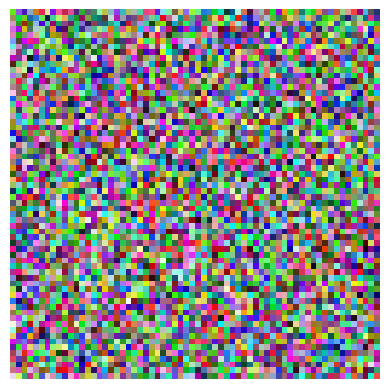

In [9]:
visualize_random_noise_image(data_loader)

### Computing Gradients 

In [20]:
gradients_across_batches = []
for images in data_loader:

    # Create a new tensor with the same data but reshaped, ensuring it's a leaf
    input = torch.tensor(images.clone().view(images.size(0), -1), requires_grad=True)
    input_gradients = torch.zeros_like(input[0])

    for i in range(10):
        predictions = model.linear_in(input)
        #predictions = model(input)
        loss = torch.sum(predictions[:,i]) # return x before out in forward pass for 1024

        loss.backward()

        input_gradients += torch.mean(input.grad, axis=0)**2

        input.grad.zero_()


    #if input_gradients is not None:
    #    mean_gradients = torch.mean(input_gradients, dim=0)
    
    gradients_across_batches = [input_gradients] #.append(mean_gradients)


    break



/var/folders/bj/l1ndbbhd1gq9wlgybtnxvr5r0000gn/T/ipykernel_17993/3174234974.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(images.clone().view(images.size(0), -1), requires_grad=True)


In [21]:
stacked_gradients = torch.stack(gradients_across_batches, dim=0) 
mean_gradient = torch.mean(stacked_gradients, dim=0)

In [22]:
mean_gradient=np.array(mean_gradient).reshape(3, 64, 64)

In [23]:
channel1=mean_gradient[0, :, :]
channel2=mean_gradient[1, :, :]
channel3=mean_gradient[2, :, :]

### Visualize results

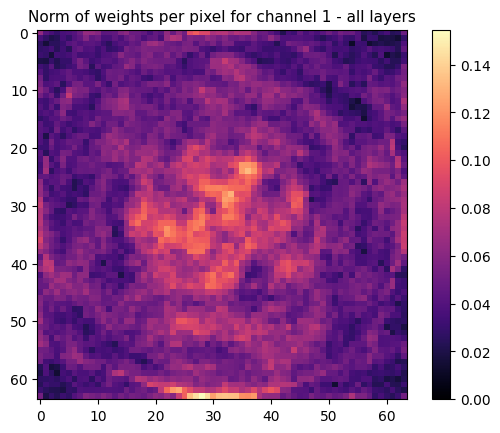

In [24]:
plt.imshow(np.sqrt(channel1), cmap='magma', vmin=0)
plt.title('Norm of weights per pixel for channel 1 - all layers', size=11)
plt.colorbar()